## ライブラリインストール

In [2]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

In [3]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

seed_value = 42
set_randvalue(seed_value)

## CSVロード

In [4]:
# train.csvが元のラベルごとにディレクトリに保存されていたデータから作成したcsv
df = pd.read_csv("../data/input/csvs/train.csv")
df["label"] = df["label"].astype(str)
df.head(3)

,image,label
0,img_100026.jpg,0
1,img_10003.jpg,0
2,img_100050.jpg,0


## モデル作成

In [44]:
# EfficientNetB0のモデルを作成
def create_model(weight_flg=False, lr=0.01):
    weight = None
    if weight_flg:
        weight = "../model/efficientnetb0_notop.h5" # ImageNetで学習されたモデルをロード
    # include_top=False; 全結合層なし
    base_model = EfficientNetB0(weights=weight, include_top=False, pooling='avg', input_shape=(224,224,3))
#     base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling='avg', input_shape=(224,224,3))
    x = Dense(512, activation='relu')(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(base_model.input, output)
    
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 学習

### CutMix generator

In [6]:
# source https://github.com/DevBruce/CutMixImageDataGenerator_For_Keras
import random
class CutMixImageDataGenerator():
    def __init__(self, generator1, generator2, img_size, batch_size):
        self.batch_index = 0
        self.samples = generator1.samples
        self.class_indices = generator1.class_indices
        self.generator1 = generator1
        self.generator2 = generator2
        self.img_size = img_size
        self.batch_size = batch_size

    def reset_index(self):  # Ordering Reset (If Shuffle is True, Shuffle Again)
        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def reset(self):
        self.batch_index = 0
        self.generator1.reset()
        self.generator2.reset()
        self.reset_index()

    def get_steps_per_epoch(self):
        quotient, remainder = divmod(self.samples, self.batch_size)
        return (quotient + 1) if remainder else quotient
    
    def __len__(self):
        self.get_steps_per_epoch()

    def __next__(self):
        if self.batch_index == 0: self.reset()

        crt_idx = self.batch_index * self.batch_size
        if self.samples > crt_idx + self.batch_size:
            self.batch_index += 1
        else:  # If current index over number of samples
            self.batch_index = 0

        reshape_size = self.batch_size
        last_step_start_idx = (self.get_steps_per_epoch()-1) * self.batch_size
        if crt_idx == last_step_start_idx:
            reshape_size = self.samples - last_step_start_idx
            
        X_1, y_1 = self.generator1.next()
        X_2, y_2 = self.generator2.next()
        
        cut_ratio = np.random.beta(a=1, b=1, size=reshape_size)
        cut_ratio = np.clip(cut_ratio, 0.2, 0.8)
        label_ratio = cut_ratio.reshape(reshape_size, 1)
        cut_img = X_2

        X = X_1
        for i in range(reshape_size):
            cut_size = int((self.img_size-1) * cut_ratio[i])
            y1 = random.randint(0, (self.img_size-1) - cut_size)
            x1 = random.randint(0, (self.img_size-1) - cut_size)
            y2 = y1 + cut_size
            x2 = x1 + cut_size
            cut_arr = cut_img[i][y1:y2, x1:x2]
            cutmix_img = X_1[i]
            cutmix_img[y1:y2, x1:x2] = cut_arr
            X[i] = cutmix_img
            
        y = y_1 * (1 - (label_ratio ** 2)) + y_2 * (label_ratio ** 2)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [7]:
# Hyper parameters
img_size = 224
batch_size = 16
epochs = 250

In [8]:
# Generator作成
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # rotation range
    width_shift_range=30/img_size, # 30 pixel
    height_shift_range=30/img_size, # 30 pixel
    zoom_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_datagenerator1 = train_datagen.flow_from_dataframe(
    df,
    directory='../data/input/imgs/train/imgs/',
    x_col='image',
    y_col='label',
    target_size=(img_size, img_size),
    class_mode='categorical',
    batch_size=10,
#     seed=seed_value,
    shuffle=True
)

train_datagenerator2 = train_datagen.flow_from_dataframe(
    df,
    directory='../data/input/imgs/train/imgs/',
    x_col='image',
    y_col='label',
    target_size=(img_size, img_size),
    class_mode='categorical',
    batch_size=10,
#     seed=seed_value,
    shuffle=True
)

Found 22424 validated image filenames belonging to 10 classes.
Found 22424 validated image filenames belonging to 10 classes.


In [12]:
# !! Define CutMixImageDataGenerator !!
train_generator = CutMixImageDataGenerator(
    generator1=train_datagenerator1,
    generator2=train_datagenerator2,
    img_size=224,
    batch_size=10,
)

In [13]:
X, y = train_generator.__next__()

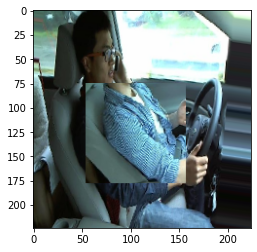

In [15]:
import matplotlib.pyplot as plt
hoge  = np.reshape(X[5], (224,224,3))
#貼り付け
plt.imshow(hoge)
#表示
plt.show()

In [39]:
%%time
batch_size = 16
# 学習と評価データでのラベルの分布数を一定に保ち学習
skf = KFold(n_splits = 5, shuffle=True, random_state=42)
splitter = skf.split(df["image"],df["label"])
for i, (train_ids, valid_ids) in enumerate(splitter, 1):

    # データ生成
    train, valid = df.iloc[train_ids], df.iloc[valid_ids]
    train_datagenerator1 = train_datagen.flow_from_dataframe(
        train,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
#         seed=seed_value
        shuffle=True
    )
    
    train_datagenerator2 = train_datagen.flow_from_dataframe(
        train,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
#         seed=seed_value
        shuffle=True
    )
    
    train_datagenerator = CutMixImageDataGenerator(
        generator1=train_datagenerator1,
        generator2=train_datagenerator2,
        img_size=img_size,
        batch_size=batch_size,
    )

    valid_datagenerator = valid_datagen.flow_from_dataframe(
        valid,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
        seed=seed_value
    )
    
    model = create_model()
    
    # 早期終了
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    
    # 早期終了するのでval_lossが小さいモデルを保存
    model_path = '../model/' +  'Train004_' + "fold" + str(i) + "_best_model.h5"
    checkpoint = ModelCheckpoint(
                    filepath=model_path,
                    monitor='val_loss',
                    save_best_only=True,
                    period=1)
    
    history = model.fit(
        train_datagenerator,
        steps_per_epoch=int(len(train)//batch_size),
        epochs=epochs,
        validation_data=valid_datagenerator,
        validation_steps=int(len(valid)//batch_size),
        verbose=1,
        shuffle=True,
        callbacks=[early_stop, checkpoint])

Found 17939 validated image filenames belonging to 10 classes.
Found 17939 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.
Epoch 1/250
1121/1121 [==============================] - 352s 314ms/step - loss: 2.2815 - accuracy: 0.1407 - val_loss: 1.9280 - val_accuracy: 0.2558
Epoch 2/250
1121/1121 [==============================] - 353s 315ms/step - loss: 2.0983 - accuracy: 0.2264 - val_loss: 1.6654 - val_accuracy: 0.2971
Epoch 3/250
1121/1121 [==============================] - 350s 312ms/step - loss: 1.9720 - accuracy: 0.2993 - val_loss: 1.4451 - val_accuracy: 0.5337
Epoch 4/250
1121/1121 [==============================] - 347s 310ms/step - loss: 1.8411 - accuracy: 0.4053 - val_loss: 1.0760 - val_accuracy: 0.6556
Epoch 5/250
1121/1121 [==============================] - 350s 312ms/step - loss: 1.6712 - accuracy: 0.5303 - val_loss: 0.6955 - val_accuracy: 0.7799
Epoch 6/250
1121/1121 [==============================] - 347s 309ms

In [45]:
%%time
batch_size = 16
# 学習と評価データでのラベルの分布数を一定に保ち学習
skf = KFold(n_splits = 5, shuffle=True, random_state=42)
splitter = skf.split(df["image"],df["label"])
for i, (train_ids, valid_ids) in enumerate(splitter, 1):
    if i == 1: continue
    if i == 2: continue
    if i == 3: continue
    if i == 4: continue
    print(i, "Fold目")
    # データ生成
    train, valid = df.iloc[train_ids], df.iloc[valid_ids]
    train_datagenerator1 = train_datagen.flow_from_dataframe(
        train,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
#         seed=seed_value
        shuffle=True
    )
    
    train_datagenerator2 = train_datagen.flow_from_dataframe(
        train,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
#         seed=seed_value
        shuffle=True
    )
    
    train_datagenerator = CutMixImageDataGenerator(
        generator1=train_datagenerator1,
        generator2=train_datagenerator2,
        img_size=img_size,
        batch_size=batch_size,
    )

    valid_datagenerator = valid_datagen.flow_from_dataframe(
        valid,
        directory='../data/input/imgs/train/imgs/',
        x_col='image',
        y_col='label',
        target_size=(img_size, img_size),
        class_mode='categorical',
        batch_size=batch_size,
        seed=seed_value
    )
    
    model = create_model(lr=0.0001)
#     model.load_weights('../model/Train004_3_fold5_best_model.h5')
    
    # 早期終了
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    
    # 早期終了するのでval_lossが小さいモデルを保存
    model_path = '../model/' +  'Train004_' + "fold" + str(i) + "_best_model.h5"
    checkpoint = ModelCheckpoint(
                    filepath=model_path,
                    monitor='val_loss',
                    save_best_only=True,
                    period=1)
    
    history = model.fit(
        train_datagenerator,
        steps_per_epoch=int(len(train)//batch_size),
        epochs=epochs,
        validation_data=valid_datagenerator,
        validation_steps=int(len(valid)//batch_size),
        verbose=1,
        shuffle=True,
        callbacks=[early_stop, checkpoint])

5 Fold目
Found 17940 validated image filenames belonging to 10 classes.
Found 17940 validated image filenames belonging to 10 classes.
Found 4484 validated image filenames belonging to 10 classes.
Epoch 1/250
1121/1121 [==============================] - 351s 313ms/step - loss: 2.3203 - accuracy: 0.1012 - val_loss: 2.3042 - val_accuracy: 0.1234
Epoch 2/250
1121/1121 [==============================] - 350s 313ms/step - loss: 2.2933 - accuracy: 0.1258 - val_loss: 2.1555 - val_accuracy: 0.1877
Epoch 3/250
1121/1121 [==============================] - 449s 401ms/step - loss: 2.2188 - accuracy: 0.1781 - val_loss: 1.9462 - val_accuracy: 0.2777
Epoch 4/250
1121/1121 [==============================] - 350s 312ms/step - loss: 2.1341 - accuracy: 0.2106 - val_loss: 1.6560 - val_accuracy: 0.3757
Epoch 5/250
1121/1121 [==============================] - 351s 314ms/step - loss: 2.0244 - accuracy: 0.2744 - val_loss: 1.4403 - val_accuracy: 0.4757
Epoch 6/250
1121/1121 [==============================] - 34

## 推論

In [46]:
submit = pd.read_csv('../data/input/csvs/sample_submission.csv')

test_generator = test_datagen.flow_from_dataframe(
    submit,
    directory='../data/input/imgs/test/',
    x_col='img',
    y_col='c0', # ダミー変数
    target_size=(img_size, img_size),
    class_mode=None,
    batch_size=1,
    verbose=1,
    shuffle=False
)

columns = submit.columns.values
labels = submit.columns[1:].values

def inference(fold_num):
    model = create_model()
    weight_path = '../model/Train004_fold' + str(fold_num) + '_best_model.h5'
    output_path = '../data/output/Train004_fold' + str(fold_num) + '_sub.csv'
    model.load_weights(weight_path)
    
    pred = model.predict(test_generator, verbose=1)
    pred_df = pd.DataFrame(columns=columns)
    pred_df['img'] = submit['img']
    pred_df[labels] = pred
    pred_df.to_csv(output_path, index=False)

Found 79726 validated image filenames.


In [47]:
for i in range(1,6):
    inference(i)

79726/79726 [==============================] - 446s 6ms/step


#### アンサンブル：単純平均

In [48]:
submit = pd.read_csv('../data/input/csvs/sample_submission.csv')
columns = submit.columns.values
labels = submit.columns[1:].values

ensemble = 0
for i in range(1,6):
    path = "../data/output/Train004_fold" + str(i) +"_sub.csv"
    ensemble += pd.read_csv(path).values[:,1:] / 5 # fold数で割る

ensemble_df = pd.DataFrame(columns=columns)
ensemble_df['img'] = submit['img']
ensemble_df[labels] = ensemble

ensemble_df.to_csv("../data/output/Train004_ensemble_sub.csv", index=False)